In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp "/content/drive/MyDrive/Colab Notebooks/Thesis/kaggle.json"  ~/.kaggle

In [ ]:
! kaggle datasets download -d apollo2506/eurosat-dataset

100% 2.04G/2.04G [00:24<00:00, 79.0MB/s]
100% 2.04G/2.04G [00:24<00:00, 89.4MB/s]


In [ ]:
! cp "/content/eurosat-dataset.zip" "/content/drive/MyDrive/Colab Notebooks/Thesis"

In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/eurosat-dataset.zip"

In [ ]:
datasets_dir = "/content/EuroSAT"

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
epochs = 30

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

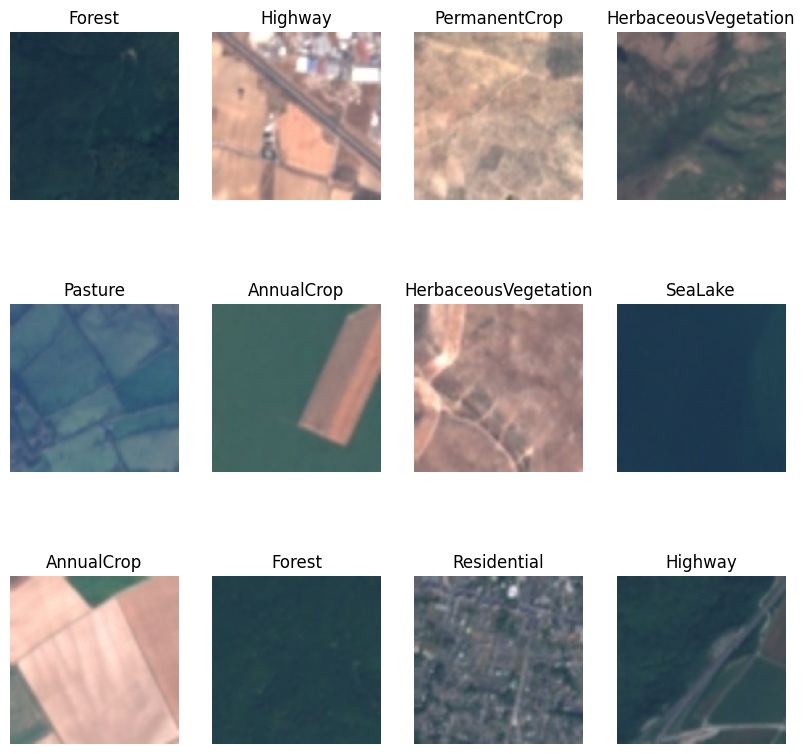

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"""
ploting image
"""

plt.figure(figsize=(10,10))
"""
Take only one batch
Each batch size is now 32
so Every batch has 32 images
"""
for image_batch,label_batch in train_data.take(1):
    """Ploting only 8 pictures of them"""
    for i in range(0,12):
        """Subploting them 3 rows and 4 columns"""
        plt.subplot(3,4,i+1)
        """Image data 0-255"""
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

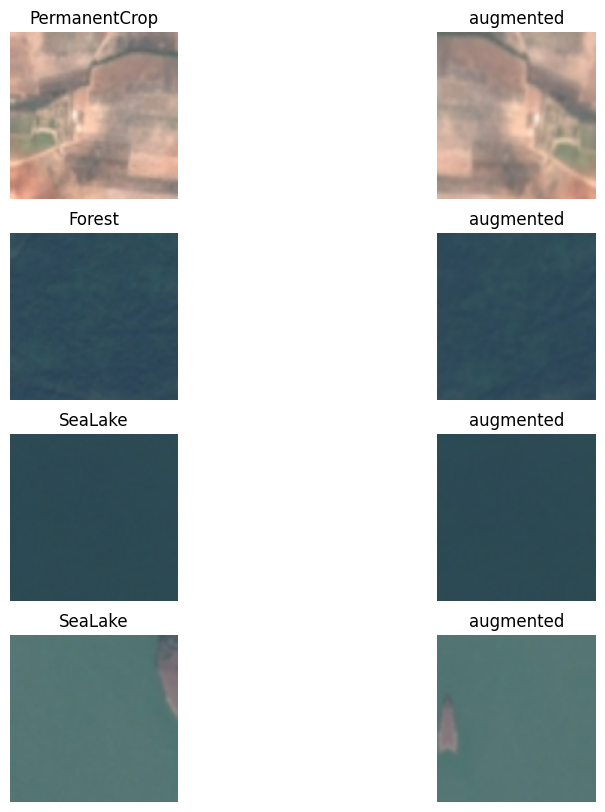

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

In [ ]:
gdrive_path = "/content/drive/MyDrive/Colab Notebooks/Thesis"

In [ ]:
checkpoint_path =f"{gdrive_path}/CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
import tensorflow as tf

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

#Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

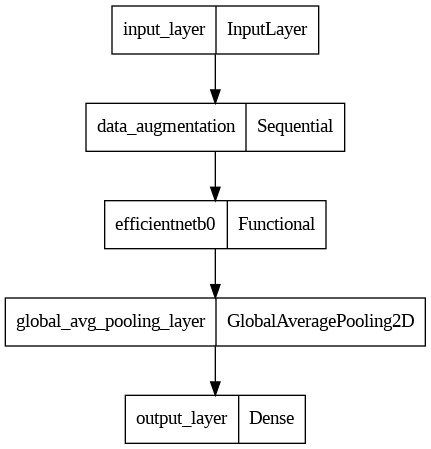

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    # show_shapes=True,
    # show_dtype=False,
    # show_layer_names=True,
    # rankdir='TB',
    # expand_nested=False,
    dpi=96,
    # layer_range=None,
    # show_layer_activations=False,
    # show_trainable=False
)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/30
675/675 [==============================] - 23s 34ms/step - loss: 0.1600 - accuracy: 0.9449 - val_loss: 0.1582 - val_accuracy: 0.9465
Epoch 2/30
675/675 [==============================] - 24s 35ms/step - loss: 0.1579 - accuracy: 0.9433 - val_loss: 0.1614 - val_accuracy: 0.9457
Epoch 3/30
675/675 [==============================] - 23s 34ms/step - loss: 0.1549 - accuracy: 0.9471 - val_loss: 0.1589 - val_accuracy: 0.9470
Epoch 4/30
675/675 [==============================] - 52s 76ms/step - loss: 0.1613 - accuracy: 0.9427 - val_loss: 0.1519 - val_accuracy: 0.9496
Epoch 5/30
675/675 [==============================] - 24s 36ms/step - loss: 0.1540 - accuracy: 0.9453 - val_loss: 0.1548 - val_accuracy: 0.9483
Epoch 6/30
675/675 [==============================] - 24s 36ms/step - loss: 0.1501 - accuracy: 0.9454 - val_loss: 0.1585 - val_accuracy: 0.9465
Epoch 7/30
675/675 [==============================] - 24s 35ms/step - loss: 0.1562 - accuracy: 0.9454 - val_loss: 0.1576 - val_accuracy:

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

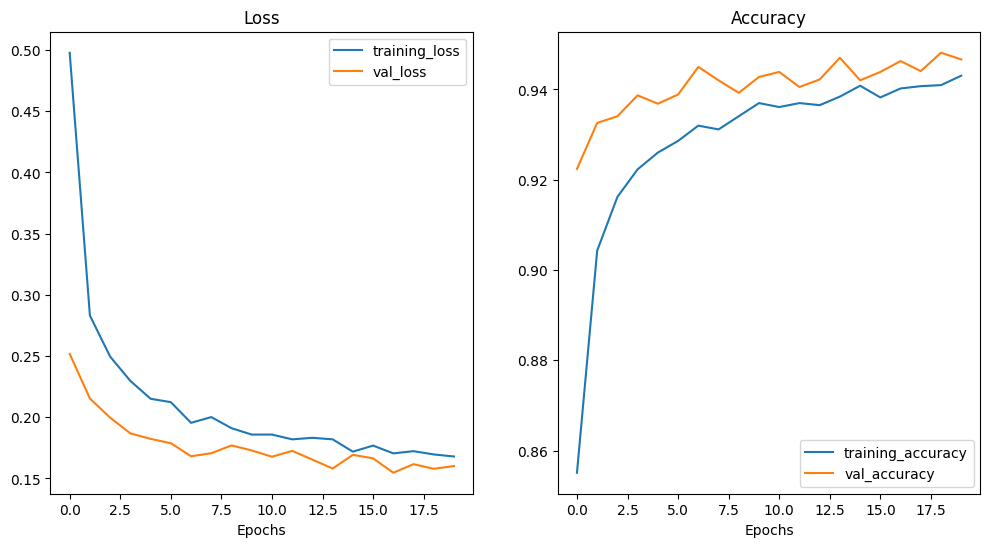

In [ ]:
plot_loss_curves(history)

In [ ]:
model.evaluate(train_data), model.evaluate(test_data)

169/169 [==============================] - 122s 724ms/step - loss: 0.1602 - accuracy: 0.9467


([0.13753876090049744, 0.9530555605888367],
 [0.16020135581493378, 0.9466666579246521])

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )

  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)


1/1 [==============================] - 1s 607ms/step


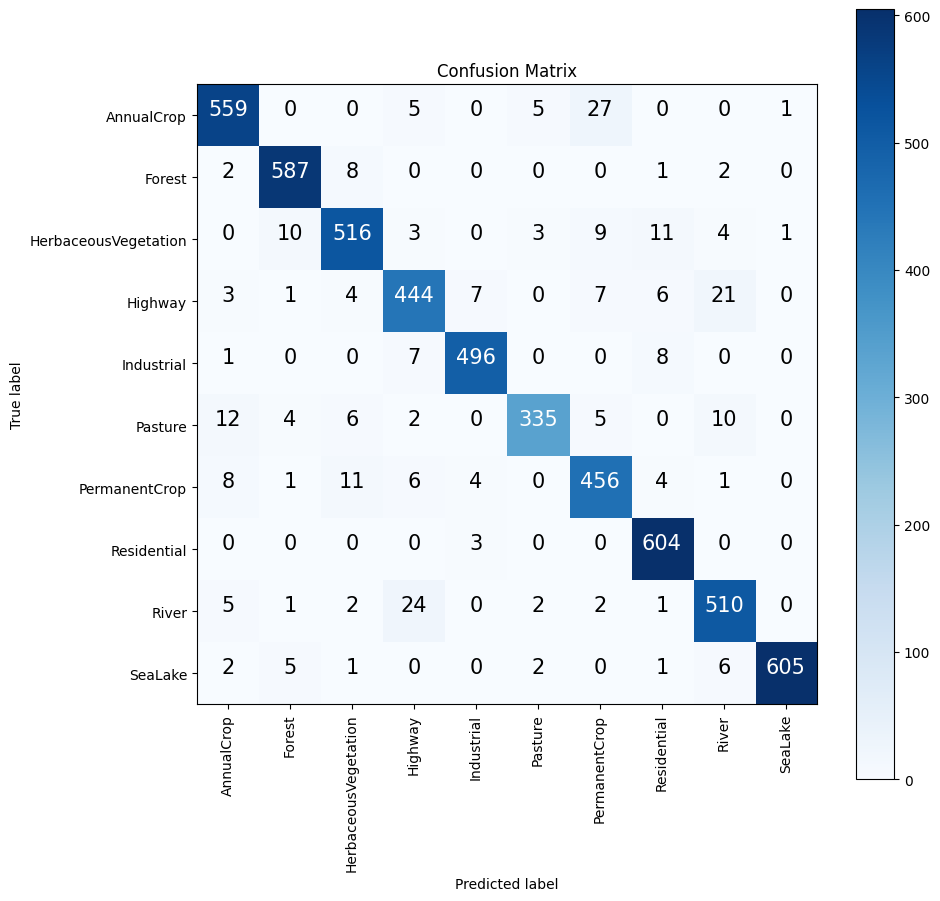

In [ ]:
make_confusion_matrix(y_true, y_pred, class_names)

1/1 [==============================] - 2s 2s/step


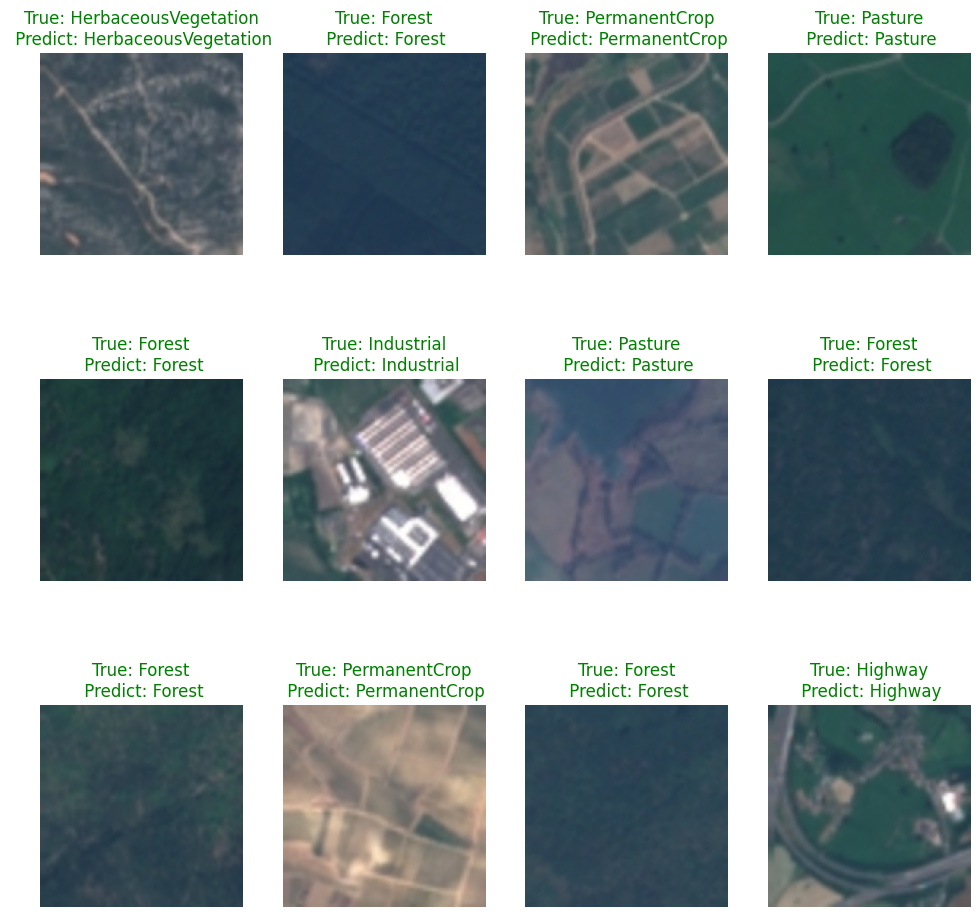

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")